In [1]:
## Visualizing, sampling and data loading
#import squarify
import os 
import PIL
import math 
import cv2
import random 
import pandas as pd 
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

## Data modeling
import tensorflow as tf
from keras import Sequential
from sklearn.model_selection import cross_val_score
from keras import backend as k 
from tensorflow import keras as keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc,roc_auc_score
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer , Input, Dense, Dropout,Conv2D,BatchNormalization,Flatten,GaussianNoise,MaxPooling2D

#Model evalution 
from torchmetrics import Precision,Recall , Accuracy , AUROC
import torch
from scipy .optimize import brentq
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore",category=UserWarning,module='sklearn.metrics')


In [2]:
def load_dataset(path):
    labels = []
    images = []
    
    for folder in os.listdir(path):
        for lr in os.listdir(path+'/'+folder):
            for image in os.listdir(path+'/'+folder+'/'+lr):
                if image.endswith('b') is False:
                    images.append(path+'/'+folder+'/'+lr+'/'+image)
                    labels.append(folder+'-'+lr)
                    
    df = pd.DataFrame(list(zip(labels,images)), columns=['Label','ImagePath'])
    return df , labels , images

In [3]:
df ,labels,images = load_dataset('/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand')

In [4]:
df

Label                                          ImagePath
0      437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
1      437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
2      437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
3      437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
4      437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
...      ...                                                ...
19995  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19996  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19997  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19998  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19999  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...

[20000 rows x 2 columns]

In [5]:
def missing_values(df):
    missing_count = df.isnull().sum()
    missing_percentages = pd.DataFrame({
        'Column': missing_count.index,
        'Counts': missing_count.values,
        'Percentage': (missing_count.values / len(df)) * 100
    })
    return missing_percentages


In [6]:
missing_values(df)

Column  Counts  Percentage
0      Label       0         0.0
1  ImagePath       0         0.0

In [7]:
def explore_data(df):
    head = pd.DataFrame(df.head())
    tail = pd.DataFrame(df.tail())
    
    nunique = pd.DataFrame(df.nunique(),columns=['#_of_Unique'])
    describe = pd.DataFrame(df.describe())
    dtypes = pd.DataFrame(df.dtypes,columns=['Datatype'])
    labels_distribution = pd.DataFrame(df['Label'].value_counts())
    results = {
        'Table 2: Dataset Head:':head,
        'Table 3: Dataset Tail:':tail,
        'Table 4: Dataset Numerical Describtion: ':describe,
        'Table 5: Missing Values By Percentage': missing_values(df), 
        'Table 6: Dataset Columns Data types: ':dtypes,
        'Table 7: Number of uniques in the datasets:':nunique,
        'Table 8: Labels Distribution:':labels_distribution
    }
    return results

In [8]:
explore_data(df)

{'Table 2: Dataset Head:':    Label                                          ImagePath
 0  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
 1  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
 2  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
 3  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
 4  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...,
 'Table 3: Dataset Tail:':        Label                                          ImagePath
 19995  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
 19996  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
 19997  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
 19998  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
 19999  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...,
 'Table 4: Dataset Numerical Describtion: ':         Label                                          ImagePath
 count   20000                                              20000
 unique   2000

In [9]:
def print_dataset_exploration(results):
    for operation,dataframe in results.items():
        print(f"{operation}")
        if operation == 'Table 6: Missing Values By Percentage':
            print("Total Sum of Missing Percentage: " , dataframe['Percentage'].sum())
        display(dataframe)

In [10]:
print_dataset_exploration(explore_data(df))

Table 2: Dataset Head:


Label                                          ImagePath
0  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
1  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
2  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
3  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
4  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...

Table 3: Dataset Tail:


Label                                          ImagePath
19995  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19996  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19997  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19998  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19999  715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...

Table 4: Dataset Numerical Describtion: 


Label                                          ImagePath
count   20000                                              20000
unique   2000                                              20000
top     715-L  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...
freq       10                                                  1

Table 5: Missing Values By Percentage


Column  Counts  Percentage
0      Label       0         0.0
1  ImagePath       0         0.0

Table 6: Dataset Columns Data types: 


Datatype
Label       object
ImagePath   object

Table 7: Number of uniques in the datasets:


#_of_Unique
Label             2000
ImagePath        20000

Table 8: Labels Distribution:


count
Label       
715-L     10
437-R     10
437-L     10
515-R     10
515-L     10
...      ...
768-L     10
642-R     10
642-L     10
057-R     10
057-L     10

[2000 rows x 1 columns]

In [11]:
def show_random_samples(df,num):
    random.seed(42)
    random_indices = random.sample(range(df.shape[0]),num)
    num_rows = math.ceil(num/4)
    
    fig,axes = plt.subplots(num_rows,4,figsize=(20,num_rows*5))
    for i ,idx in enumerate(random_indices):
        row = i // 4
        col = i % 4
        
        if idx < df.shape[0]:
            image_path = df.loc[idx,"ImagePath"]
            image = PIL.Image.open(image_path)
            ax = axes[row,col] if num_rows > 1 else axes[col]
            ax.imshow(image,cmap='gray')
            ax.set_title(f"Image {idx} Person Label: {df.loc[idx,'Label']}")
        
        
    plt.suptitle("Figure 3: Random Small Sample of the Dataset")
    plt.tight_layout()
    plt.show()

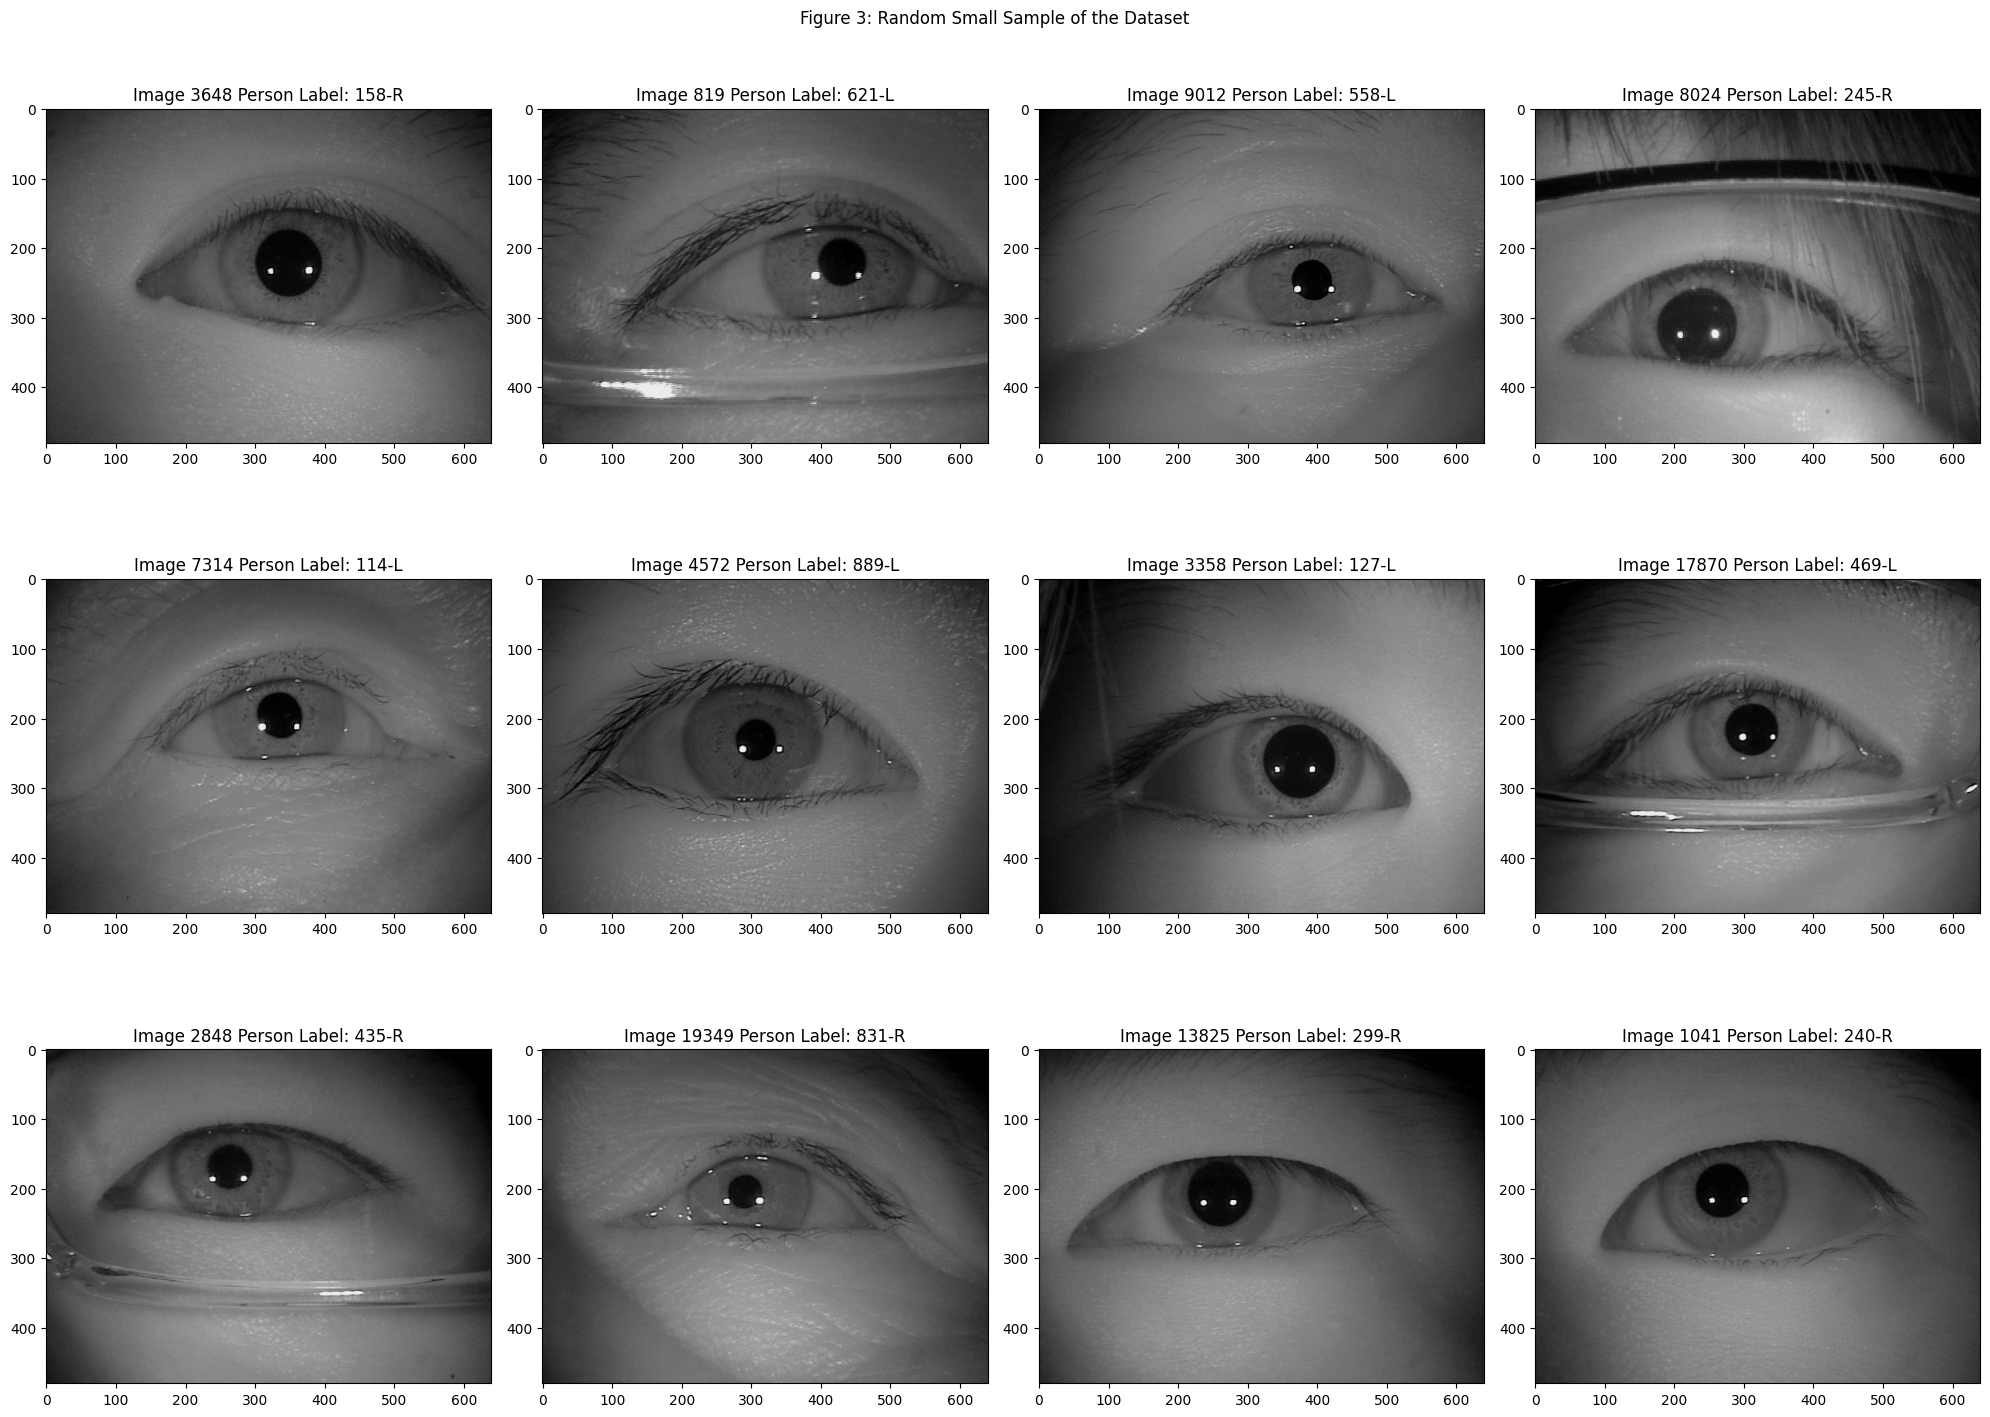

In [12]:
show_random_samples(df,12)

The width of the images:  640
The height of the images:  480
Shape (640, 480)


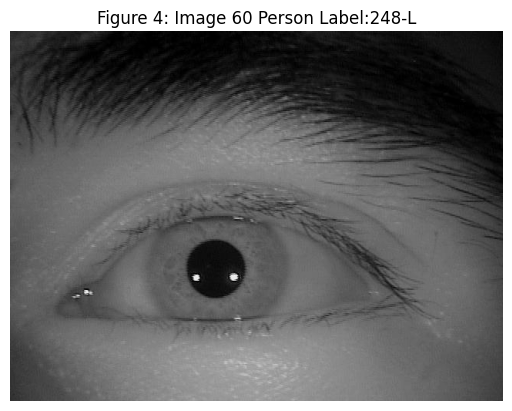

In [13]:
image_path = df.loc[60,"ImagePath"]
image = PIL.Image.open(image_path)
plt.imshow(image,cmap='gray')
plt.title(f"Figure 4: Image {60} Person Label:{df.loc[50,'Label']}")
plt.axis("off")
width,height = image.size
print("The width of the images: ", width)
print("The height of the images: ", height)
print("Shape", image.size)

In [14]:

image_sizes = []
aspect_ratios = []

for image_path in df['ImagePath']:
    image = PIL.Image.open(image_path)
    width,height = image.size
    image_sizes.append(width*height)
    aspect_ratios.append(width/height)

Text(0, 0.5, 'Frequency')

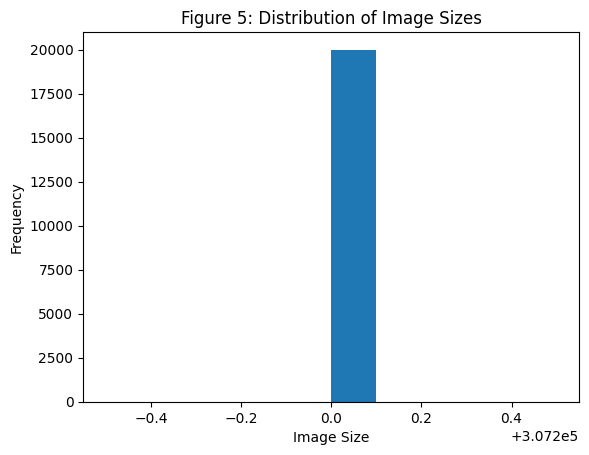

In [15]:
plt.hist(image_sizes,label ="Image Size")
plt.title("Figure 5: Distribution of Image Sizes")
plt.xlabel("Image Size")
plt.ylabel("Frequency")

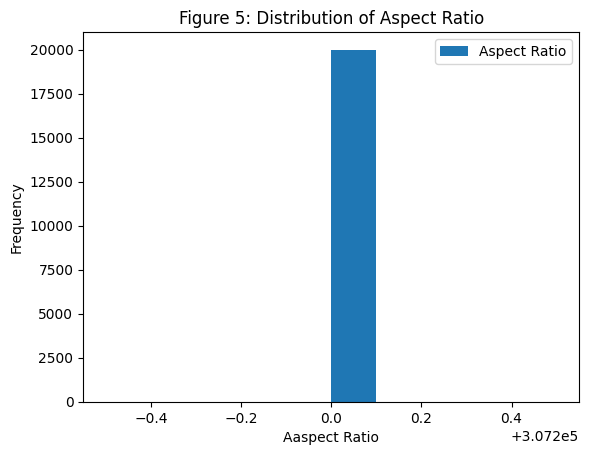

In [16]:
plt.hist(image_sizes,label ="Aspect Ratio")
plt.title("Figure 5: Distribution of Aspect Ratio")
plt.xlabel("Aaspect Ratio")
plt.ylabel("Frequency")
plt.legend()

In [17]:
pip install squarify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


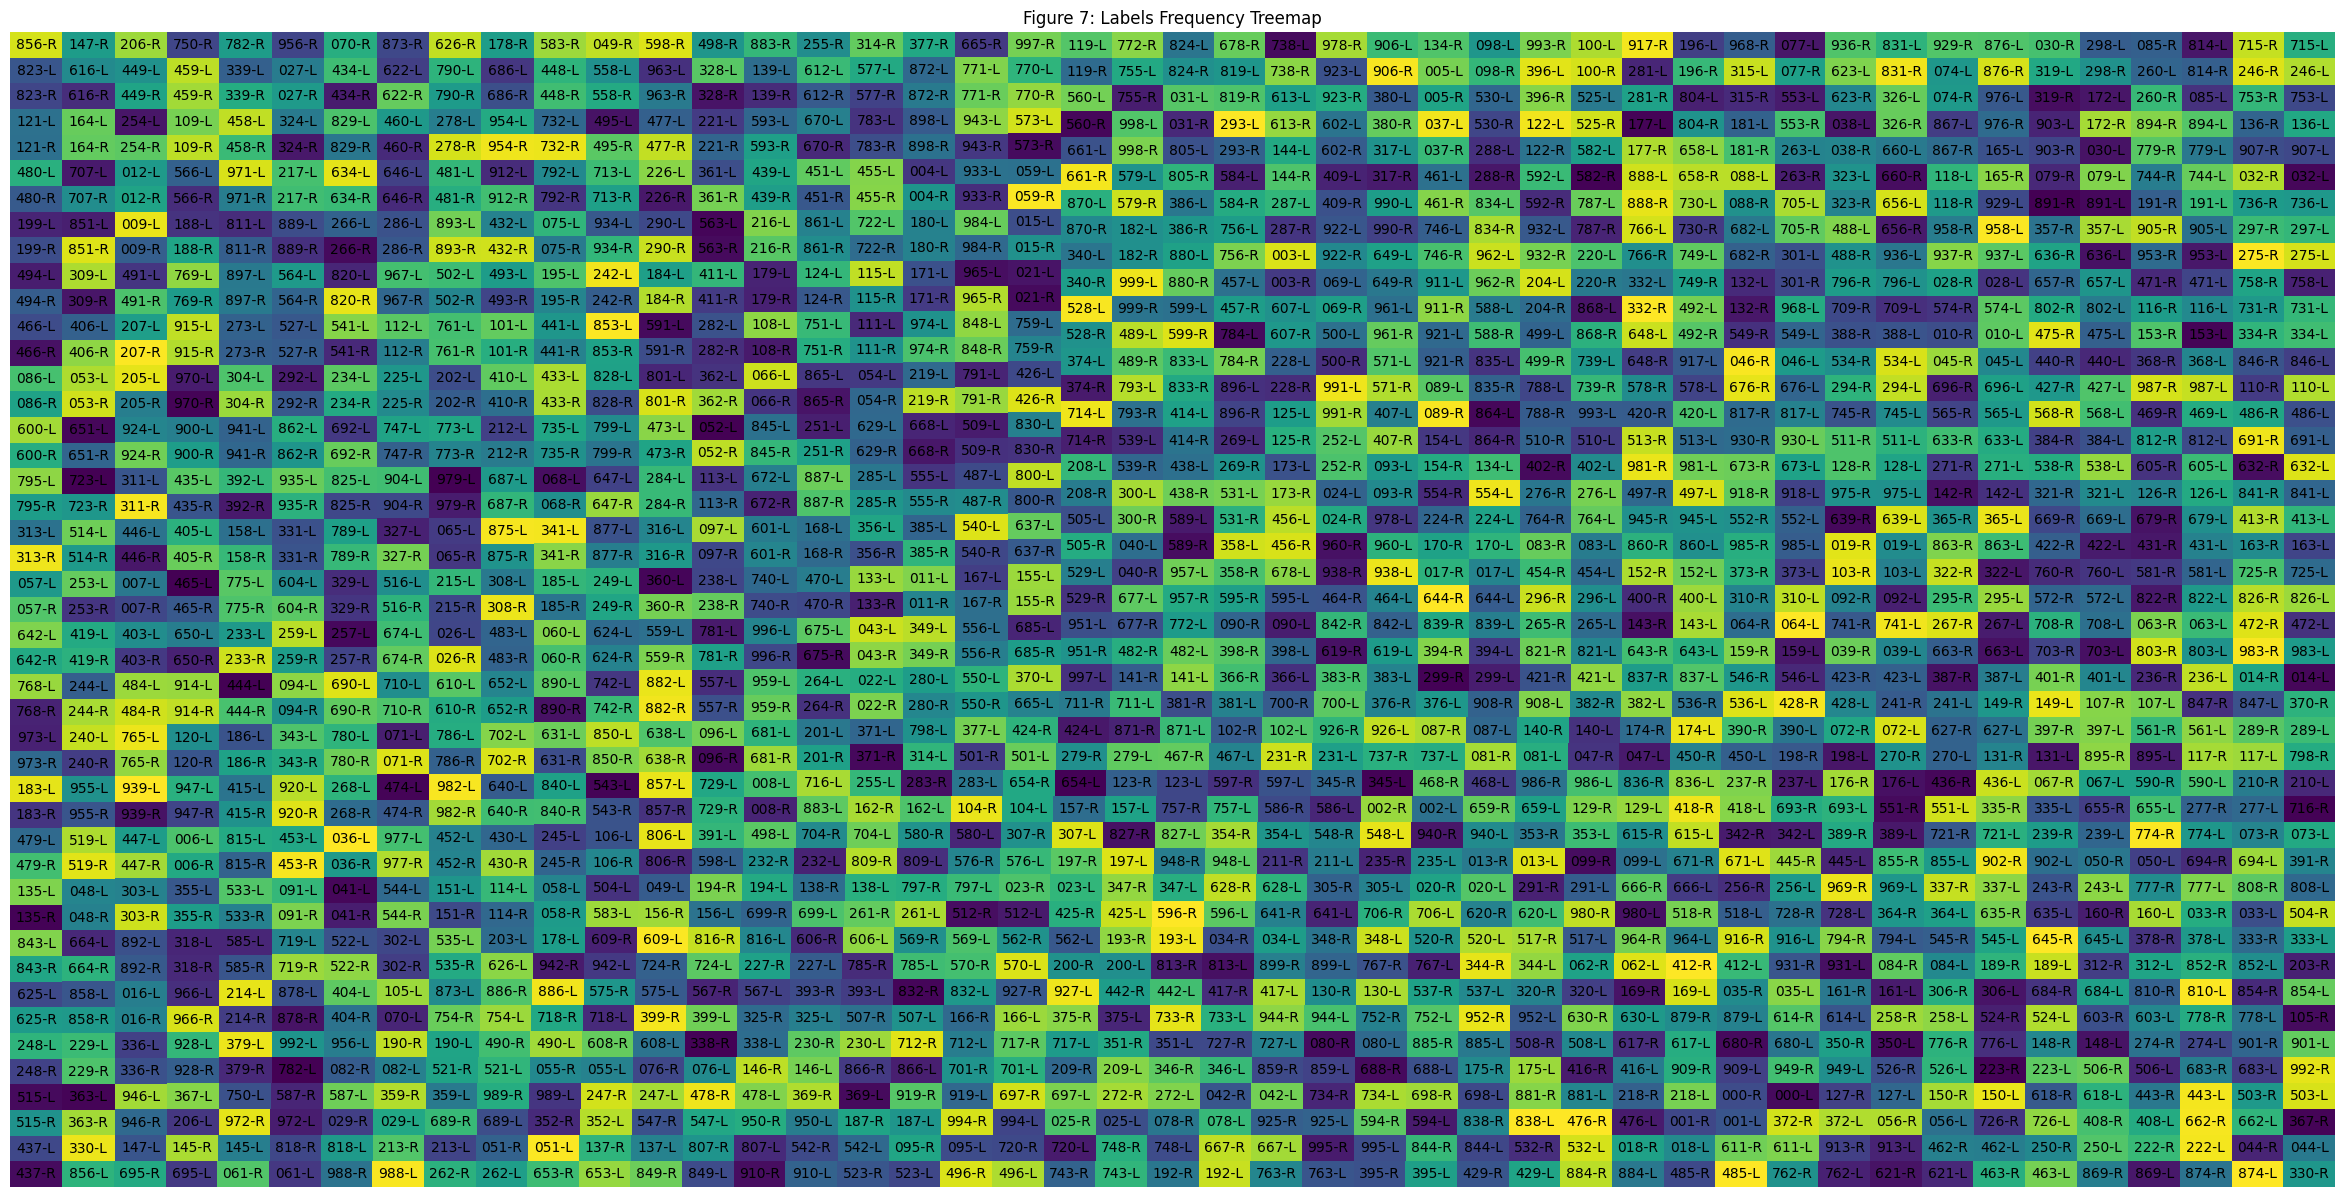

In [18]:
import squarify
plt.figure(figsize=(30,15))
squarify.plot(sizes = df['Label'].value_counts(),label = df['Label'].unique())
plt.axis('off')
plt.title("Figure 7: Labels Frequency Treemap")
plt.show()

In [19]:
SIZE = 20000
NUM_CLASSES = 2000
IMG_HEIGHT = 150
IMG_WIDTH = 150
NUM_CHANELS = 1
input_shape = (IMG_HEIGHT,IMG_WIDTH,NUM_CHANELS)

In [20]:
def resize_keep_aspect_ration(img,target_height= IMG_HEIGHT,target_width=IMG_WIDTH,pad_value=255):
    aspect_ratio = img.shape[1] /img.shape[0]
    
    
    if aspect_ratio >target_width/target_height:
        new_width = target_width
        new_height = int(target_width/aspect_ratio)
    
    else:
        new_height = target_height
        new_width = int(target_height*aspect_ratio)
    
    resized_img = cv2.resize(img,(new_width,new_height))
    
    preprocessed_img=np.full((target_height,target_width),pad_value,dtype=np.uint8)
    x_offset = (target_width - new_width) //2
    y_offset = (target_height - new_height) //2
    preprocessed_img[y_offset:y_offset + new_height,x_offset:x_offset + new_width] = resized_img
    
    return preprocessed_img

In [21]:
def preprocess_image(img_dir):
    
    img = cv2.imread(img_dir,cv2.IMREAD_GRAYSCALE)
    img = resize_keep_aspect_ration(img)
    img = img / 255
    
    return img

<function matplotlib.pyplot.show(close=None, block=None)>

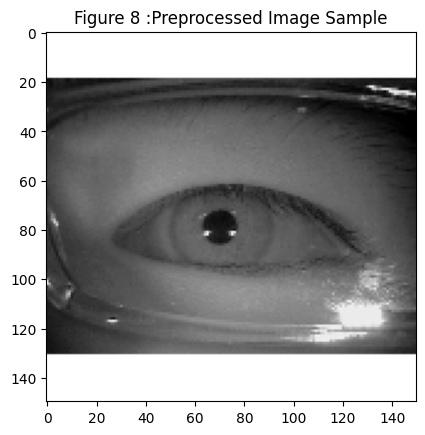

In [22]:
plt.imshow(preprocess_image(df.iloc[20]['ImagePath']),cmap="gray")
plt.title("Figure 8 :Preprocessed Image Sample")
plt.show

In [23]:
def preprocess_labels(df):
    labels = df['Label'].astype(str)
    le = LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    
    return labels

In [24]:
print("label after encoding:",preprocess_labels(df)[120])
print("Label before encoding:",df.iloc[120]['Label'])

label after encoding: 959
Label before encoding: 479-R


In [25]:
def split_dataset(preprocessed_images,preprocessed_labels,train_size=0.8,validation_size=0.1,shuffle=True):
    np.random.seed(1190652)
    indices = np.arange(SIZE)
    if shuffle:
        np.random.shuffle(indices)
    
    train_samples = int(SIZE * train_size)
    validation_samples = int(SIZE * validation_size)
    
    train_indices = indices[:train_samples]
    validation_indices = indices[train_samples:train_samples + validation_samples]
    test_indices = indices[train_samples + validation_samples:]
    
    x_train  = preprocessed_images[train_indices]
    y_train = preprocessed_labels[train_indices]
    x_valid = preprocessed_images[validation_indices]
    y_valid = preprocessed_labels[validation_indices]
    x_test = preprocessed_images[test_indices]
    y_test = preprocessed_labels[test_indices]
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [26]:
def prepare_dataset(df):
    preprocessed_images = []
    for i in range(SIZE):
        image = preprocess_image(images[i])
        preprocessed_images.append(image)
        
    preprocessed_images = np.array(preprocessed_images).reshape(-1,IMG_HEIGHT,IMG_WIDTH,NUM_CHANELS)
    preprocessed_labels = preprocess_labels(df)
    return split_dataset(preprocessed_images,preprocessed_labels)

In [ ]:
x_train,x_valid,x_test,y_train,y_valid,y_test = prepare_dataset(df)
print("Training set size:",x_train.shape)
print("Validation set size:",x_valid.shape)
print("Test set size:",x_test.shape)

In [ ]:
class CentralCrop(Layer):
    def __init__(self,central_fraction = 0.5):
        super(CentralCrop,self).__init__()
        self.central_fraction = central_fraction
        
    def call(self,inputs):
        cropped = tf.image.central_crop(inputs,central_fraction = self.central_fraction)
        return cropped

In [ ]:
data_augmentation = keras.Sequential([
    Input(shape=input_shape),
    CentralCrop(central_fraction = 0.5)
])

augmented_images = data_augmentation(x_train)

In [ ]:
print(f'Encoded Person Label is : {y_valid[70]}')
plt.imshow(augmented_images[70],cmap='gray')
plt.title("Figure 9 : Augmented image with sample")
plt.show

Model and Hyper parameter


In [48]:
EPOCHS = 200
BATCH_SIZE = 16
loss = 'sparse_categorical_crossentropy'

activation = "leaky_relu"
initial_learning_rate =  0.0010000000474974513
optimizer = Adam(learning_rate = initial_learning_rate)

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
mcp_save = ModelCheckpoint('.mdl_wts.keras', save_best_only=True, monitor='val_loss', mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='auto')

In [49]:
def create_model():
    """
    Create the model architicure and compile it, call on pre-set values.
    Returns:
        model (keras.Sequential): a model compiled with its layers
    """
    padding = 'same'
    poolpadding = 'valid'

    model = Sequential([
        Input(input_shape),
        ####### Features extraction
        
        Conv2D(32, (5, 5), padding=padding, activation=activation, name="Conv1"),
        BatchNormalization(axis=-1, name="BN1"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool1"),
        GaussianNoise(0.1, name="GaussianNoise"), 
        Dropout(0.1, name="Dropout1"),

        Conv2D(64, (5, 5), padding=padding, activation=activation, name="Conv2"),
        BatchNormalization(axis=-1, name="BN2"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool2"),
        Dropout(0.1, name="Dropout2"),

        Conv2D(128, (5, 5), padding=padding, activation=activation, name="Conv3"),
        BatchNormalization(axis=-1, name="BN3"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool3"),
        Dropout(0.25, name="Dropout3"),

        Conv2D(256, (3, 3), padding=padding, activation=activation, name="Conv4"),
        BatchNormalization(axis=-1, name="BN4"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool4"),
        Dropout(0.25, name="Dropout4"),

        Conv2D(256, (3, 3), padding=padding, activation=activation, name="Conv5"),
        BatchNormalization(axis=-1, name="BN5"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool5"),
        Dropout(0.25, name="Dropout5"),
        
        Conv2D(512, (3, 3), padding=padding, activation=activation, name="Conv6"),
        BatchNormalization(axis=-1, name="BN6"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool6"),
        Dropout(0.45, name="Dropout6"),
        
        Conv2D(512, (2, 2), padding=padding, activation=activation, name="Conv7"),
        BatchNormalization(axis=-1, name="BN7"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool7"),
        Dropout(0.5, name="Dropout7"),
        
        
        #### Flatten and fully connected layers, classifier using relu sofftmax
        Flatten(),
       # Dense(64, activation=activation, name = "Dense0"),
       # Dense(1024, activation=activation, name = "Dense6"),
        #
        Dropout(0.3, name="Dropout13"),
        
        Dense(512, activation=activation, name = "Dense3"),
        Dropout(0.1, name="Dropout11"),
        Dense(256,activation=activation,name = "Dense4"),
        Dropout(0.1, name="Dropout12"),
        Dense(128,activation=activation,name = "Dense5"),
        Dropout(0.15, name="Dropout8"),
        #Dense(128,activation=activation,name = "Dense6"),
        Dense(64, activation=activation, name = "Dense2"),
        Dropout(0.1, name="Dropout10"),
        
        Dense(32, activation=activation, name = "Dense1"),
        #Dropout(0.1, name="Dropout9"),
        
      
        Dense(2000, activation='softmax', name="SoftmaxClasses"),
    ],
    name="IRISRecognizer")
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [50]:
model = create_model()
model.summary()

Model: "IRISRecognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1 (BatchNormalization)        │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Mpool1 (MaxPooling2D)           │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GaussianNoise (GaussianNoise)   │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 75, 75, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2 (BatchNormalization)        │ (None, 75, 75, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Mpool2 (MaxPooling2D)           │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 37, 37, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3 (BatchNormalization)        │ (None, 37, 37, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Mpool3 (MaxPooling2D)           │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout3 (Dropout)              │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN4 (BatchNormalization)        │ (None, 18, 18, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Mpool4 (MaxPooling2D)           │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout4 (Dropout)              │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 9, 9, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN5 (BatchNormalization)        │ (None, 9, 9, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Mpool5 (MaxPooling2D)           │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout5 (Dropout)              │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN6 (BatchNormalization)        │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Mpool6 (MaxPooling2D)           │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout6 (Dropout)              │ (None, 2, 2, 512)      │             

 Total params: 3,881,776 (14.81 MB)

 Trainable params: 3,878,256 (14.79 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [51]:
history = model.fit(np.array(x_train), y_train, validation_data=(np.array(x_valid), y_valid), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - accuracy: 2.3481e-04 - loss: 7.6206 - val_accuracy: 5.0000e-04 - val_loss: 7.6207 - learning_rate: 0.0010
Epoch 2/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.0012 - loss: 7.4843 - val_accuracy: 0.0015 - val_loss: 7.1393 - learning_rate: 0.0010
Epoch 3/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.0024 - loss: 6.9474 - val_accuracy: 0.0015 - val_loss: 6.7190 - learning_rate: 0.0010
Epoch 4/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.0027 - loss: 6.7024 - val_accuracy: 0.0035 - val_loss: 6.6284 - learning_rate: 0.0010
Epoch 5/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.0070 - loss: 6.3893 - val_accuracy: 0.0025 - val_loss: 7.9077 - learning_rate: 0.0010
Epoch 6/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.0109 - loss: 6.0305 - val_accuracy: 0.0165 - val_loss: 5.8466 - learning_rate: 0.0010
Epoch 7/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19m

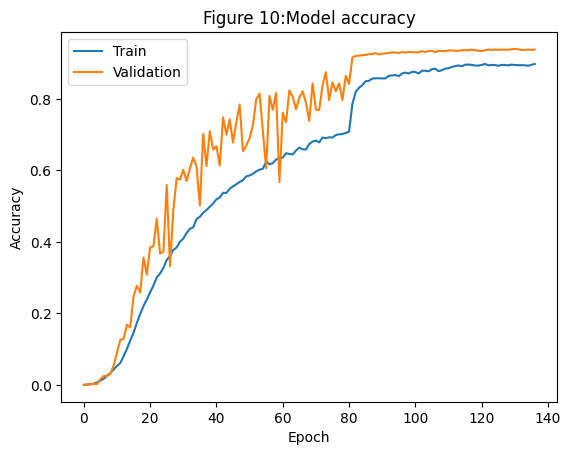

In [52]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Figure 10:Model accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()


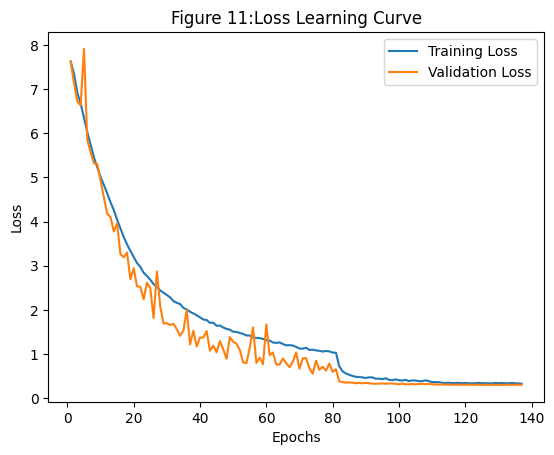

In [53]:
training_loss = history.history['loss']
validation_loss  = history.history['val_loss']
epochs = range(1,len(training_loss)+1)

plt.plot(epochs,training_loss,label= 'Training Loss')
plt.plot(epochs,validation_loss,label = 'Validation Loss')
plt.title("Figure 11:Loss Learning Curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [54]:
model.save('IRISRecognizer1.h5')
reconstructed_model = keras.models.load_model("IRISRecognizer1.h5")
test_loss,test_acc = reconstructed_model.evaluate(x_test,y_test)
print(f"Test accuracy :{test_acc*100:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9188 - loss: 0.4014
Test accuracy :92.850


In [73]:
def evaluate_model_visualize(dataset,y_true,model,class_names):
    num_rows = 8 
    num_cols = 6
    data_batch = dataset[0:num_rows*num_cols]
    predictions = model.predict(data_batch)
    plt.figure(figsize=(20, 8 ))
    num_matches = 0
    
    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows,num_cols,idx +1)
        plt.axis('off')
        plt.imshow(data_batch[idx], cmap='gray')
        
        pred_idx = np.argmax(predictions[idx])
        true_idx = y_true[idx]
        
        title = f"{class_names[true_idx]}: {class_names[pred_idx]}"
        title_obj = plt.title(title,fontdict={"fontsize":13})
        
        if pred_idx == true_idx:
            num_matches +=1
            plt.setp(title_obj,color='g')
        else:
            plt.setp(title_obj,color='r')
            
    acc = num_matches / (num_rows * num_cols)
    print("prediction accuracy:{:.2%}".format(acc))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
prediction accuracy:89.58%


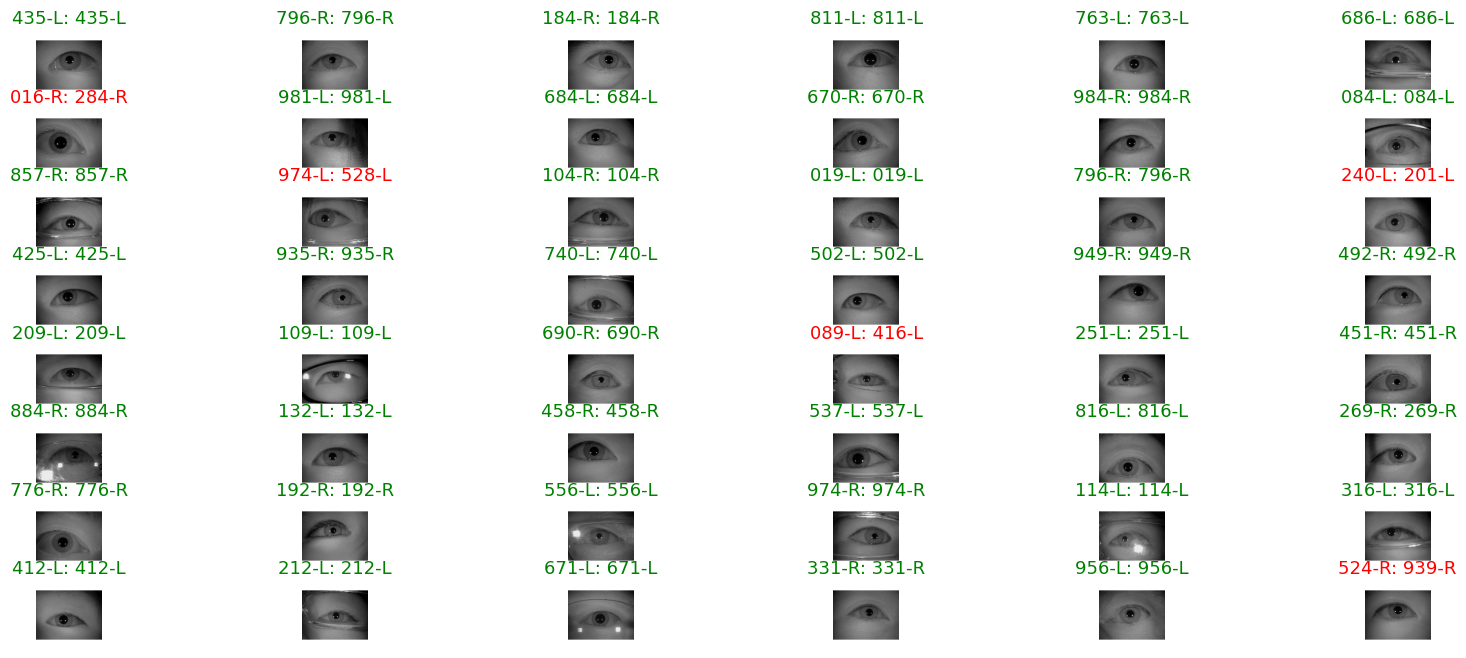

In [74]:
evaluate_model_visualize(x_test,y_test,reconstructed_model,df['Label'].unique())

In [61]:
def describe_model_confedince(reconstructed_model , x_test):
    probabilities = reconstructed_model.predict(x_test)
    y_pred = np.argmax(probabilities , axis=1)
    max_liklihoods = np.max(probabilities,axis=1)
    print("Average of (Maximum Liklihoods) for predictions:",np.average(max_liklihoods))
    print("Standard deviation of (Naximum Liklihood) for predictions:",np.std(max_liklihoods))
    print("Median of (Maximum Liklihoods) for prediction:",np.median(max_liklihoods))
    print("Maximum of (Maximum Liklihoods) for prediction:",np.max(max_liklihoods))
    print("Minimum of (Maximum Liklihoods) for prediction:",np.min(max_liklihoods))
    threshold= np.max(max_liklihoods)- np.min(max_liklihoods)
    print("Choosen threshold is :",threshold)
    return probabilities

In [62]:
probabilities = describe_model_confedince(reconstructed_model,x_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Average of (Maximum Liklihoods) for predictions: 0.9476006
Standard deviation of (Naximum Liklihood) for predictions: 0.14022838
Median of (Maximum Liklihoods) for prediction: 0.99913216
Maximum of (Maximum Liklihoods) for prediction: 1.0
Minimum of (Maximum Liklihoods) for prediction: 0.17949864
Choosen threshold is : 0.8205013


In [63]:
precision = Precision(task= 'multiclass',num_classes = 2000)
recall = Recall(task= 'multiclass',num_classes = 2000)
accuracy = Accuracy(task='multiclass',num_classes= 2000)
auroc = AUROC(task='multiclass',num_classes= 2000)

In [64]:
accuracyv = accuracy(torch.tensor(probabilities),torch.tensor(y_test))
prec = precision(torch.tensor(probabilities),torch.tensor(y_test))
rec = recall(torch.tensor(probabilities),torch.tensor(y_test))
aurc = auroc(torch.tensor(probabilities),torch.tensor(y_test))


/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [65]:
print(f"Accuracy:",{accuracyv})
print(f"Precision:",{prec})
print(f"Recall:",{rec})
print(f"Auroc:",{aurc})

Accuracy: {tensor(0.9285)}
Precision: {tensor(0.9285)}
Recall: {tensor(0.9285)}
Auroc: {tensor(0.6499)}


In [66]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 2000

for i in range(num_classes):
    y_true_binary = np.where(y_test == i, 1, 0)
    fpr[i] ,tpr[i], _ = roc_curve(y_true_binary,probabilities[:,1])
    roc_auc[i] = auc(fpr[i],tpr[i])
    

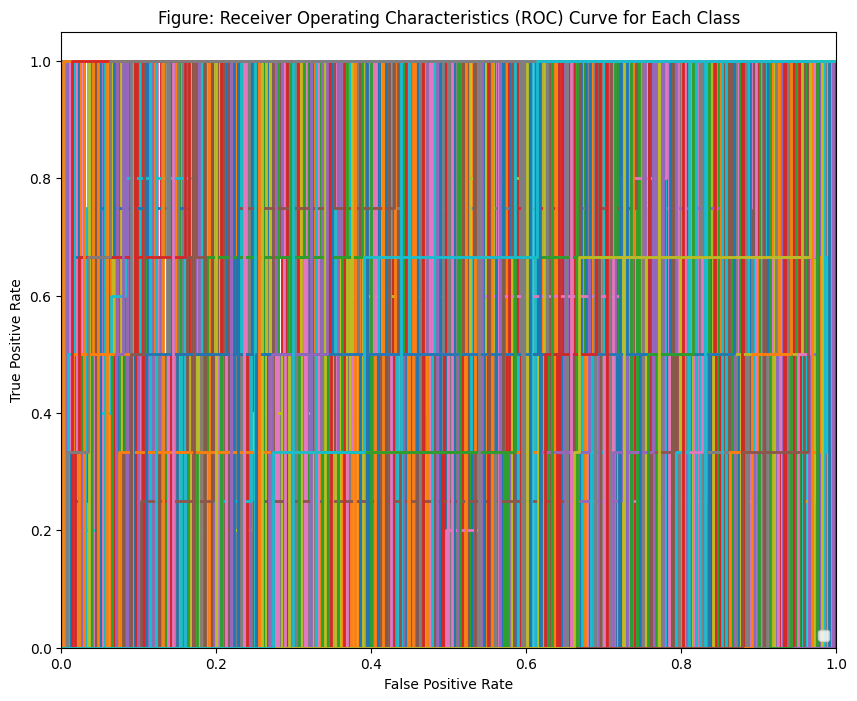

In [67]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  ## this is the state of a random classifier

for i in range(num_classes):
    if not math.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], lw=2)#, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        
plt.xlim(0.0,1.0)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure: Receiver Operating Characteristics (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

In [68]:
eer_thresholds = []

for i in range(num_classes):
    try:
        fpr_values = fpr[i]
        tpr_values = tpr[i]
        interp_fn = interp1d(fpr_values, tpr_values)
        def eer_fn(x):
            return 1.0 - x - interp_fn(x)

        eer_threshold = brentq(eer_fn, 0.0, 1.0)
        eer_thresholds.append(eer_threshold)
    except ValueError:
        continue

avg_eer_threshold = np.mean(eer_thresholds)
print(f"Equal Error Rate (EER) Threshold: {avg_eer_threshold:.4f}")

Equal Error Rate (EER) Threshold: 0.5047
